In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from   sklearn.preprocessing   import MinMaxScaler
from   sklearn.model_selection import train_test_split
from   keras.models            import Sequential
from   keras.layers            import Dense
from   keras.layers            import LSTM
from   keras.layers            import Dropout
from   keras.callbacks         import EarlyStopping
from   keras.models            import load_model

In [2]:
hr_file = "heart-rate-time-series.csv"
hr_data = pd.read_csv(hr_file, header=None)

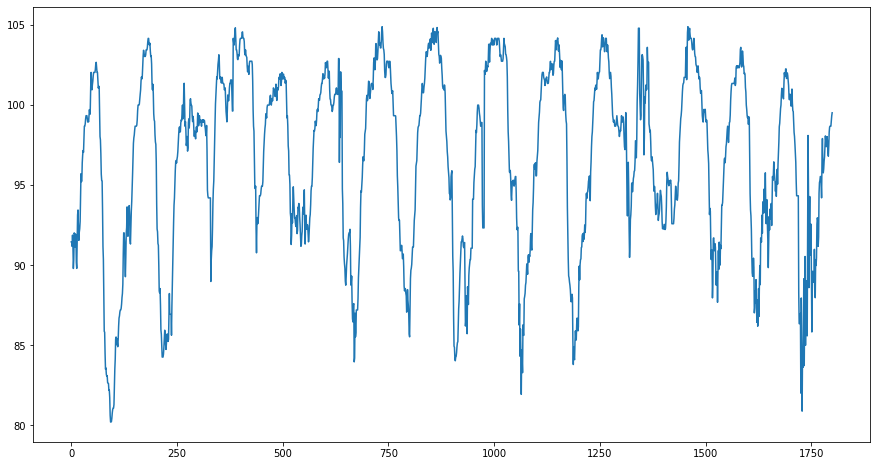

In [3]:
plt.figure(figsize=(15, 8))
plt.plot(hr_data)

plt.show()

In [4]:
# Scale features
s1 = MinMaxScaler(feature_range=(-1,1))
x1 = s1.fit_transform(hr_data)


window = 120
X = []
Y = []

for i in range(window,len(x1)):
    X.append(x1[i-window:i,:])
    Y.append(x1[i,:])

X, Y = np.array(X, dtype=np.float32), np.array(Y, dtype=np.float32)
print(X.shape, Y.shape)

(1680, 120, 1) (1680, 1)


In [5]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.2)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(1344, 120, 1) (336, 120, 1) (1344, 1) (336, 1)


In [6]:
unitss = [10, 100, 500]
drop_rates = [.1, .5, .9]
models = dict()

for units in unitss:
    for drop_rate in drop_rates:
        model = Sequential()
        model.add(LSTM(units=units, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
        model.add(Dropout(drop_rate))
        model.add(LSTM(units=units, return_sequences=True))
        model.add(Dropout(drop_rate))
        model.add(LSTM(units=units))
        model.add(Dropout(drop_rate))
        model.add(Dense(units=1))
        model.compile(optimizer = "adam", loss = "mse", metrics = ['accuracy'])
        es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=10)
        history = model.fit(x_train, y_train, epochs = 1000, batch_size = 240, callbacks=[es], verbose=1)

        models[f'u{units}d{drop_rate}'] = [model, history]
        model.save(f'model-u{units}d{drop_rate}.h5')
        # models.append(model)
        # histories.append(history)

Epoch 1/1000
6/6 [==============================] - 8s 159ms/step - loss: 0.3259 - accuracy: 0.0000e+00
Epoch 2/1000
6/6 [==============================] - 1s 140ms/step - loss: 0.2430 - accuracy: 0.0000e+00
Epoch 3/1000
6/6 [==============================] - 1s 142ms/step - loss: 0.1830 - accuracy: 0.0000e+00
Epoch 4/1000
6/6 [==============================] - 1s 136ms/step - loss: 0.1507 - accuracy: 0.0000e+00
Epoch 5/1000
6/6 [==============================] - 1s 136ms/step - loss: 0.1414 - accuracy: 7.4405e-04
Epoch 6/1000
6/6 [==============================] - 1s 134ms/step - loss: 0.1250 - accuracy: 0.0000e+00
Epoch 7/1000
6/6 [==============================] - 1s 133ms/step - loss: 0.1143 - accuracy: 7.4405e-04
Epoch 8/1000
6/6 [==============================] - 1s 134ms/step - loss: 0.1043 - accuracy: 7.4405e-04
Epoch 9/1000
6/6 [==============================] - 1s 134ms/step - loss: 0.0899 - accuracy: 7.4405e-04
Epoch 10/1000
6/6 [==============================] - 1s 136ms/st

In [8]:
predicts = dict()
for name, item in models.items():
    y_hat = item[0].predict(x_test)
    y_pred = s1.inverse_transform(y_hat)
    predicts[name] = y_pred

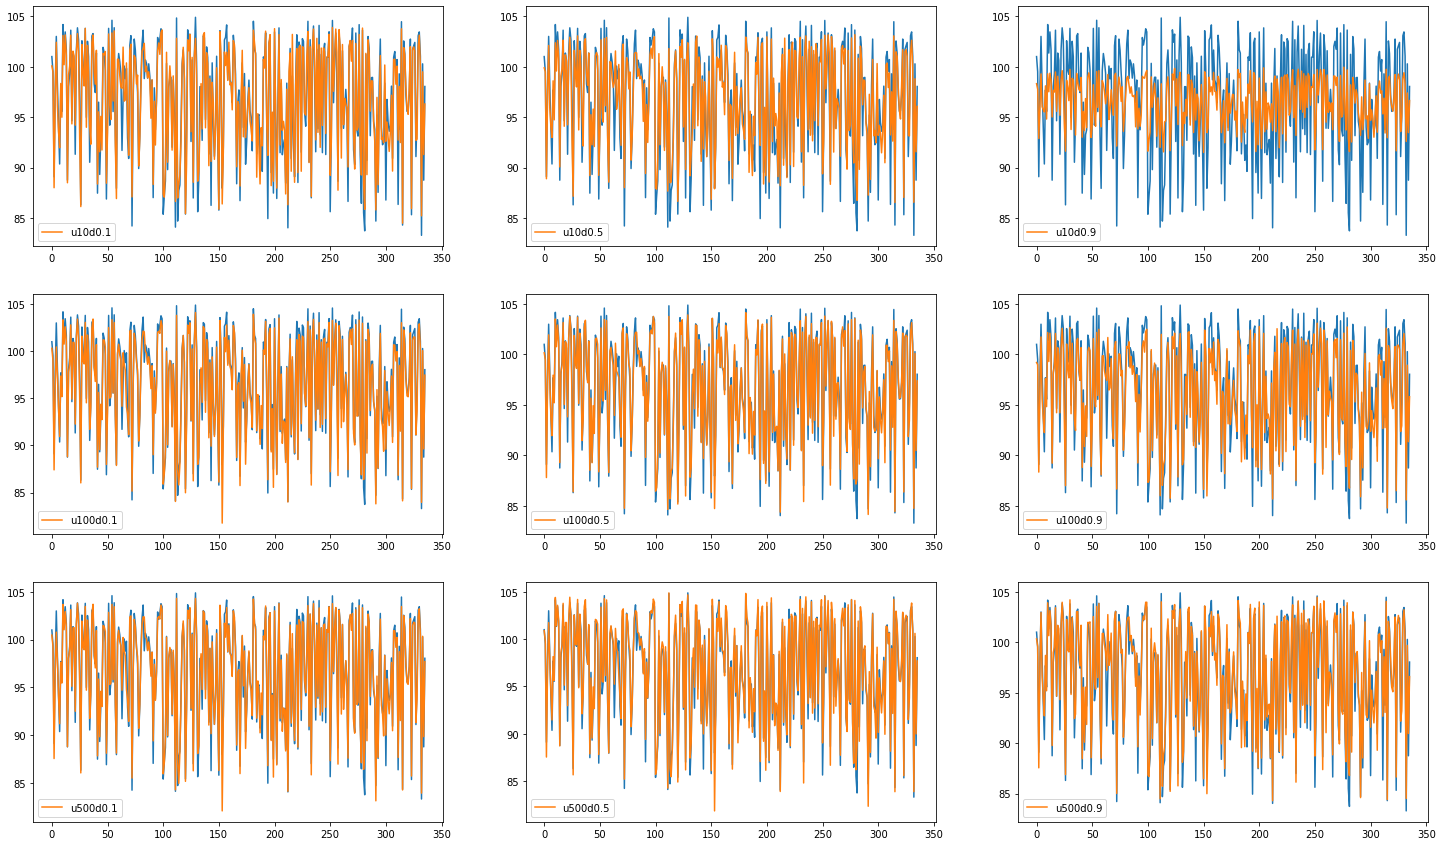

In [18]:
plt.figure(figsize=(25, 15))
i = 0


for name, y_pred in predicts.items():
    i += 1
    plt.subplot(3, 3, i)
    plt.plot(s1.inverse_transform(y_test))
    plt.plot(y_pred, label=name)
    plt.legend()

plt.show()

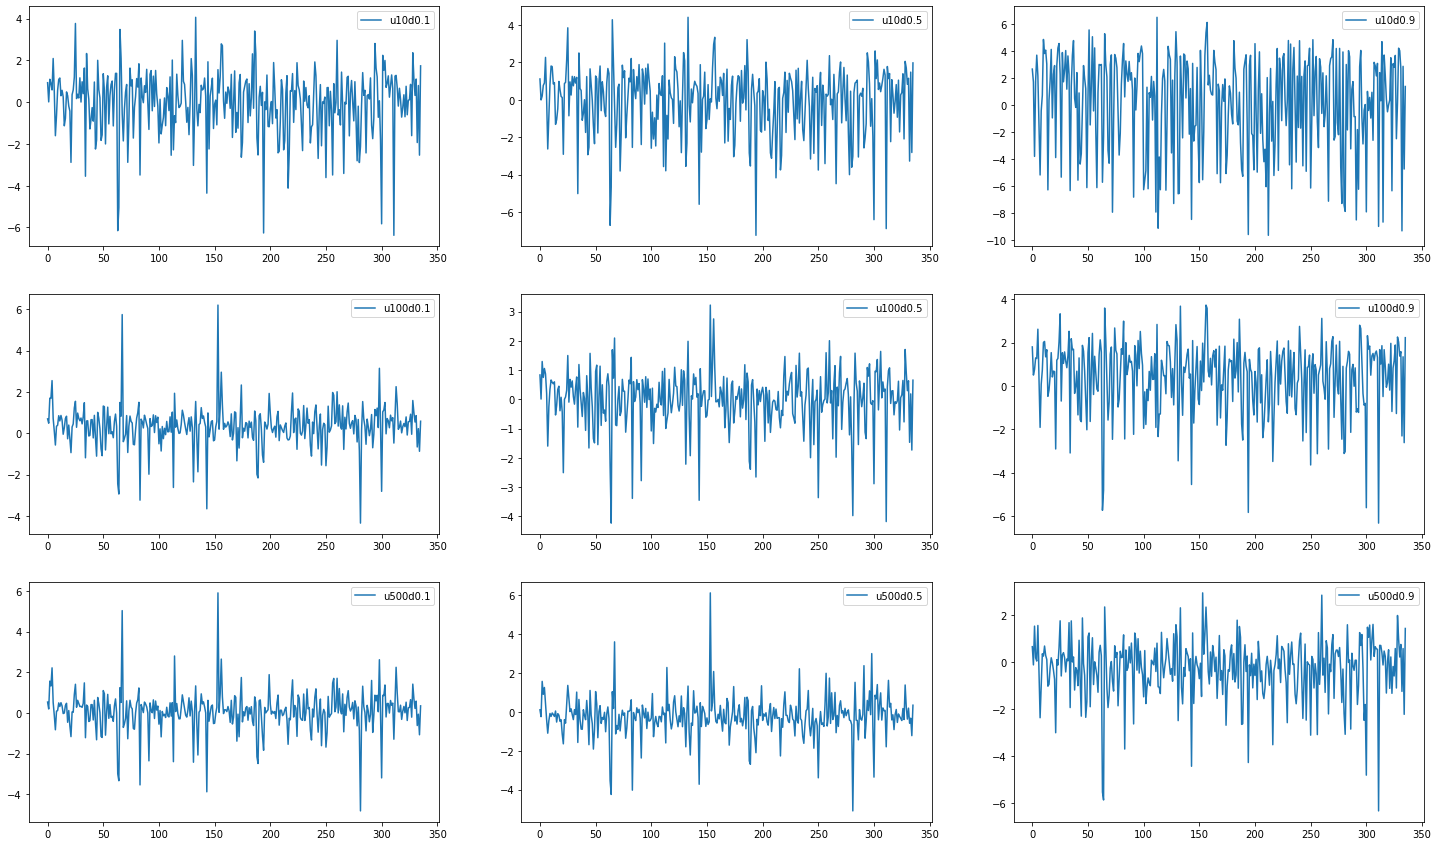

In [19]:
plt.figure(figsize=(25, 15))
i = 0


for name, y_pred in predicts.items():
    i += 1
    plt.subplot(3, 3, i)
    plt.plot(s1.inverse_transform(y_test)-y_pred, label=name)
    plt.legend()

plt.show()

result :
make model with (units=100 and drop=0.1) or (units=500 and drop=0.1) or (units=500 and drop=0.5) are better than the others, if we have no time for compiling (units=100 and drop=0.1) is best of them

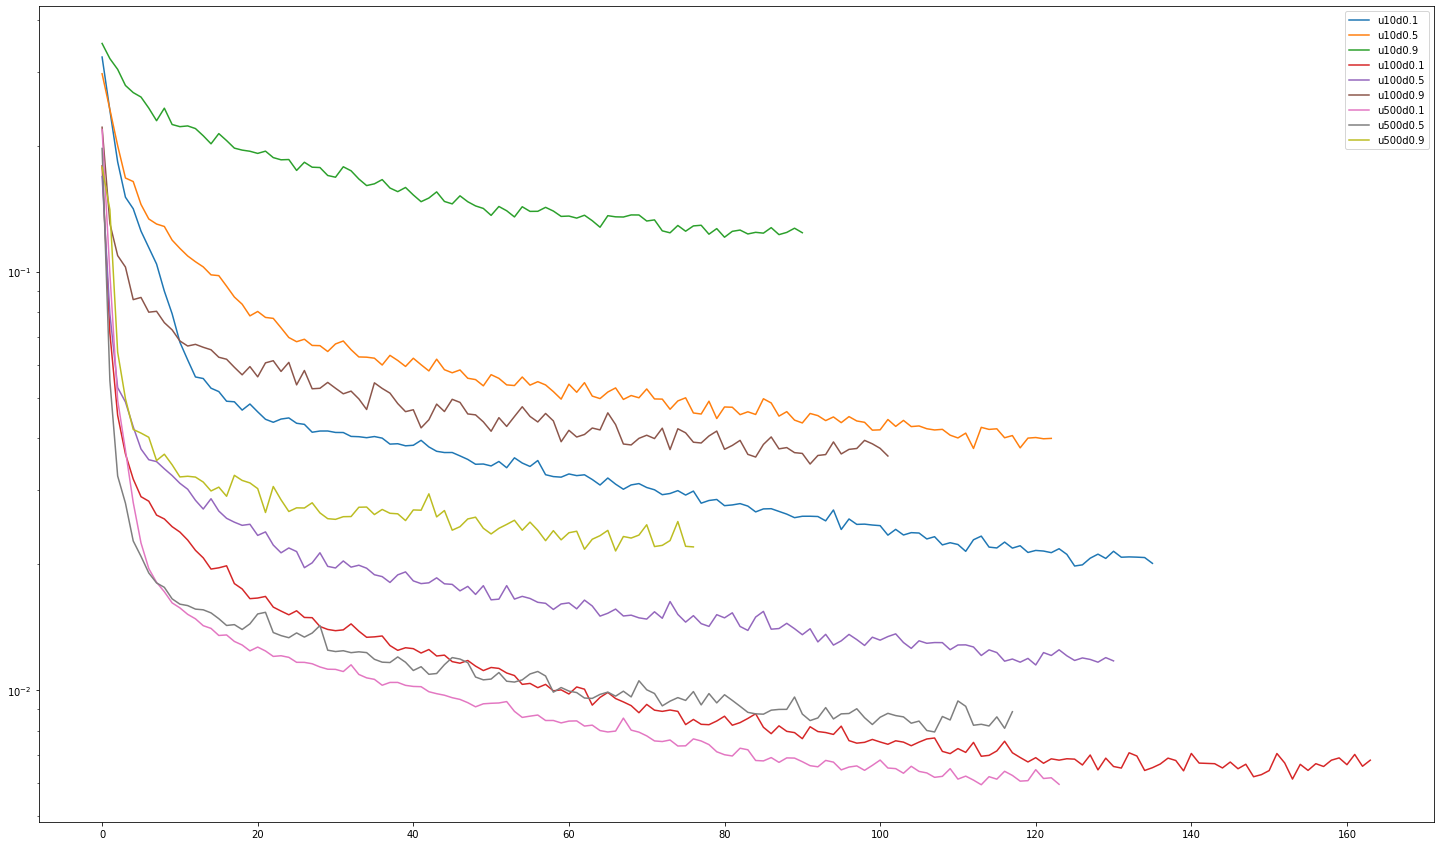

In [22]:
plt.figure(figsize=(25, 15))
i = 0


for name, y_pred in predicts.items():
    i += 1
    # plt.subplot(3, 3, i)
    plt.semilogy(models[name][1].history['loss'], label=name)

plt.legend()

plt.show()